# Modeling Notebook

## Initial Setup

In [1]:
# Warning: this notebook takes significant time to run given all the model training

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import keras
import tensorflow as tf
from keras.utils.multi_gpu_utils import multi_gpu_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D  
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasClassifier
import pickle
import matplotlib.pyplot as plt

# Importing Custom functions from code folder
import sys  
sys.path.insert(0, './code/')
import contraction
import data_preparation as dp
import visualizations as viz

params = {'axes.titlesize': 20,
          'axes.labelsize' : 16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'font.size': 14,
          'figure.figsize': (12, 8)}
plt.rcParams.update(params)

C:\Users\lelwo\anaconda3\envs\nlp-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Loading Data

In [2]:
data = pd.read_csv('./data/clean_data.zip')

In [3]:
data.head()

,label,cleaned_text,cleaned_title,no_stop_text
0,fake,sponsored links republican attacks on transgen...,virginia republican wants schools to check chi...,sponsored links republican attacks transgender...
1,fake,mental images my pictures ask where does the t...,mental images,mental images pictures ask truth end lies begi...
2,fake,but it appears not all mr zuckerbergs own empl...,denzel washington hit by facebook fake news st...,appears mr zuckerbergs employees satisfied res...
3,fake,genius nickname email password by clicking cre...,song lyrics knowledge,genius nickname email password clicking create...
4,fake,getting ballot access can be hard for smaller ...,thinking about writing in a candidate on elect...,getting ballot access hard smaller campaigns f...


### Encoding and Spliting

In [4]:
label = LabelEncoder()
X = data['cleaned_text']
y = label.fit_transform(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## TF-IDF Models

Our first models will used TF-IDF to embedded the full text.

In [5]:
tfidf = TfidfVectorizer(max_features=1000)
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

### Naive Bayesian

In [6]:
bayes_model = MultinomialNB()
bayes_cv = cross_val_score(bayes_model, X_train_vectorized, y_train)
bayes_cv

array([0.80418987, 0.8127772 , 0.80134013, 0.80728577, 0.80502076])

In [7]:
bayes_model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [8]:
print('Training Scores:')
dp.get_scores(bayes_model, X_train_vectorized, y_train)

Training Scores:


{'Accuracy': 0.8073496659242761,
 'Precision': 0.806966786782127,
 'Recall': 0.8073496659242761,
 'F1 Score': 0.8070704521379753}

In [9]:
print('Test Scores:')
dp.get_scores(bayes_model, X_test_vectorized, y_test)

Test Scores:


{'Accuracy': 0.8062056469877699,
 'Precision': 0.805768543681682,
 'Recall': 0.8062056469877699,
 'F1 Score': 0.8057512159741653}

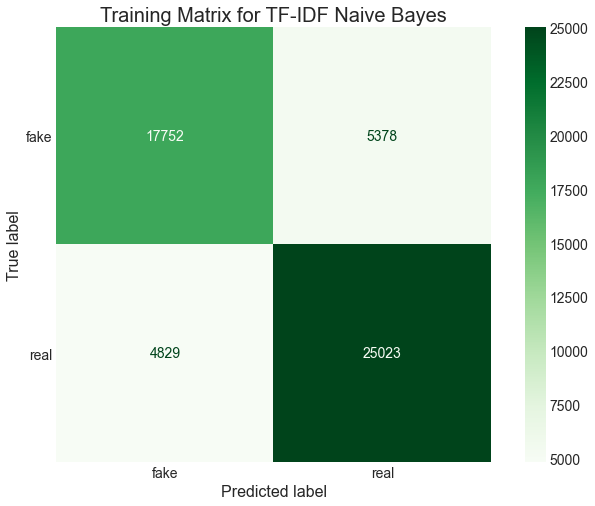

In [10]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for TF-IDF Naive Bayes')
plt.savefig(f'images/Models/train_TFIDF_bayes.png')
plt.show()

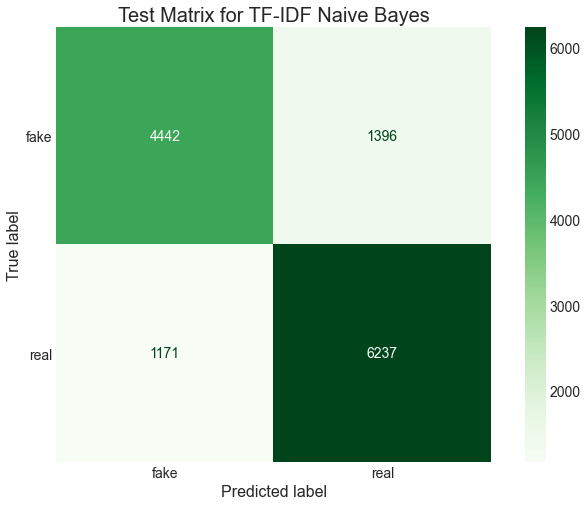

In [11]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for TF-IDF Naive Bayes')
plt.savefig(f'images/Models/test_TFIDF_bayes.png')
plt.show()

### Logistic

In [12]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_cv = cross_val_score(logistic_model, X_train_vectorized, y_train)
logistic_cv

array([0.87996603, 0.89110126, 0.88976972, 0.88372971, 0.88212533])

In [13]:
logistic_model.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=1000)

In [14]:
print('Training Scores:')
dp.get_scores(logistic_model, X_train_vectorized, y_train)

Training Scores:


{'Accuracy': 0.8927937790192896,
 'Precision': 0.8927301364920305,
 'Recall': 0.8927937790192896,
 'F1 Score': 0.892567671316183}

In [15]:
print('Test Scores:')
dp.get_scores(logistic_model, X_test_vectorized, y_test)

Test Scores:


{'Accuracy': 0.8896270572248226,
 'Precision': 0.88972164112265,
 'Recall': 0.8896270572248226,
 'F1 Score': 0.8893192294695682}

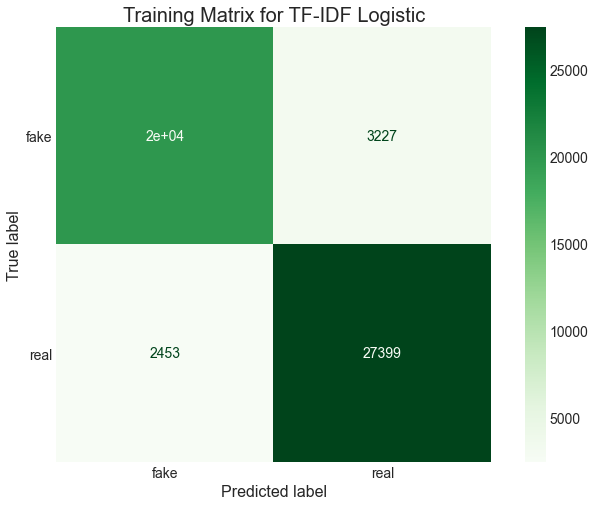

In [16]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for TF-IDF Logistic')
plt.savefig(f'images/Models/train_TFIDF_logistic.png')
plt.show()

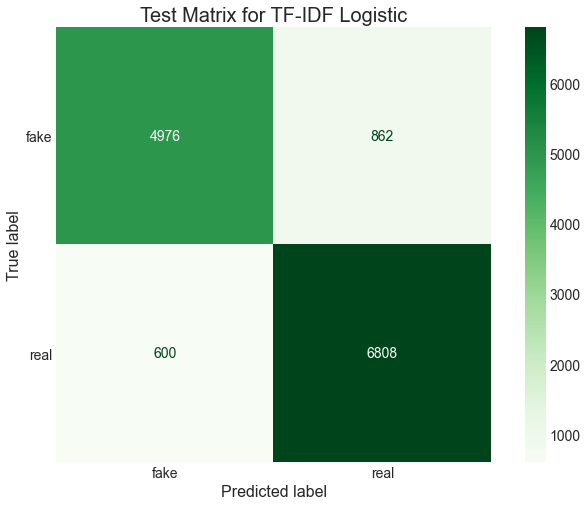

In [17]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for TF-IDF Logistic')
plt.savefig(f'images/Models/train_TFIDF_logistic.png')
plt.show()

### Random Forest

In [18]:
forest_model = RandomForestClassifier()
forest_cv = cross_val_score(forest_model, X_train_vectorized, y_train, n_jobs=4, verbose=1)
forest_cv

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  7.4min finished


array([0.90770973, 0.9156365 , 0.90515289, 0.91166478, 0.90534164])

In [19]:
forest_model.fit(X_train_vectorized, y_train)

RandomForestClassifier()

In [20]:
print('Training Scores:')
dp.get_scores(forest_model, X_train_vectorized, y_train)

Training Scores:


{'Accuracy': 0.9964704994148956,
 'Precision': 0.9964746694243503,
 'Recall': 0.9964704994148956,
 'F1 Score': 0.9964697244277121}

In [21]:
print('Test Scores:')
dp.get_scores(forest_model, X_test_vectorized, y_test)

Test Scores:


{'Accuracy': 0.917711007096482,
 'Precision': 0.9186384578114332,
 'Recall': 0.917711007096482,
 'F1 Score': 0.9173399300057317}

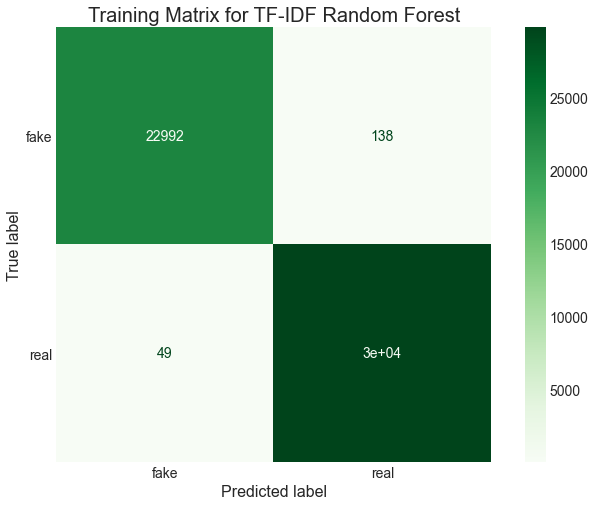

In [22]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for TF-IDF Random Forest')
plt.savefig(f'images/Models/train_TFIDF_forest.png')
plt.show()

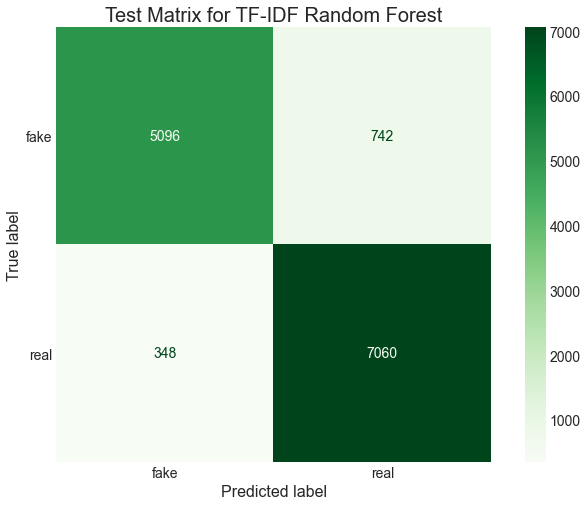

In [23]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for TF-IDF Random Forest')
plt.savefig(f'images/Models/train_TFIDF_forest.png')
plt.show()

### XGBoost

In [24]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4)
xgb_cv = cross_val_score(xgb_model, X_train_vectorized, y_train)
xgb_cv

array([0.9066717 , 0.91752383, 0.90619102, 0.9104379 , 0.90420914])

In [25]:
xgb_model.fit(X_train_vectorized, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [26]:
print('Training Scores:')
dp.get_scores(xgb_model, X_train_vectorized, y_train)

Training Scores:


{'Accuracy': 0.9597410441281945,
 'Precision': 0.9599398250735441,
 'Recall': 0.9597410441281945,
 'F1 Score': 0.9596637275519716}

In [27]:
print('Test Scores:')
dp.get_scores(xgb_model, X_test_vectorized, y_test)

Test Scores:


{'Accuracy': 0.9146157330514872,
 'Precision': 0.9146243407429487,
 'Recall': 0.9146157330514872,
 'F1 Score': 0.9144720988798027}

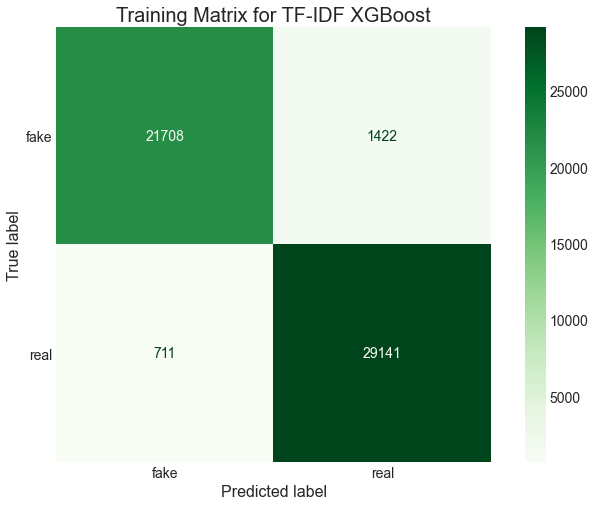

In [28]:
ConfusionMatrixDisplay.from_estimator(xgb_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for TF-IDF XGBoost')
plt.savefig(f'images/Models/train_TFIDF_xgb.png')
plt.show()

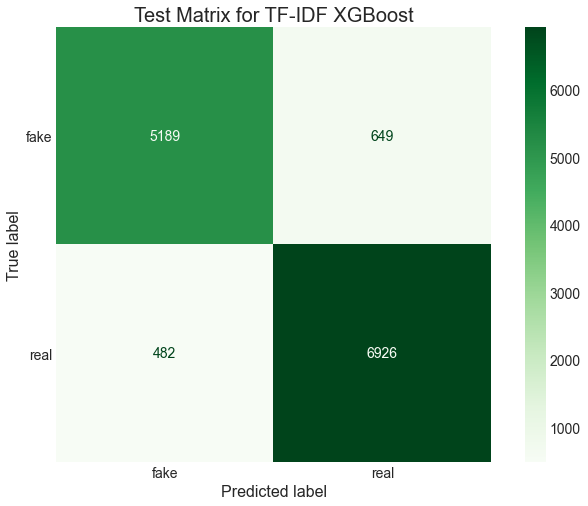

In [29]:
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for TF-IDF XGBoost')
plt.savefig(f'images/Models/train_TFIDF_xgb.png')
plt.show()

### RNN

In [30]:
y_one_hot = pd.get_dummies(data['label']).values
X_rnn = data['cleaned_text']
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_one_hot, test_size=0.2, random_state=42)

In [31]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(X_train))
train_list_tokenized = tokenizer.texts_to_sequences(X_train_rnn)
X_train_padded = sequence.pad_sequences(train_list_tokenized, maxlen=500)
test_list_tokenized = tokenizer.texts_to_sequences(X_test_rnn)
X_test_padded = sequence.pad_sequences(test_list_tokenized, maxlen=500)

In [32]:
baseline_rnn = Sequential()
embedding_size = 200
baseline_rnn.add(Embedding(10000, embedding_size))
baseline_rnn.add(LSTM(100, return_sequences=True))
baseline_rnn.add(GlobalMaxPool1D())
baseline_rnn.add(Dropout(0.5))
baseline_rnn.add(Dense(100, activation='relu'))
baseline_rnn.add(Dropout(0.5))
baseline_rnn.add(Dense(2, activation='softmax'))
baseline_rnn.compile(loss='categorical_crossentropy', 
                              optimizer='adam', 
                              metrics=['accuracy'])
baseline_rnn.summary()

In [33]:
callback = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
baseline_rnn_val = baseline_rnn.fit(X_train_padded,
                                    y_train_rnn, 
                                    epochs=20, 
                                    batch_size=64, 
                                    validation_split=0.2,
                                    callbacks=[callback])

Epoch 1/20
663/663 [==============================] - 495s 746ms/step - loss: 0.3194 - accuracy: 0.8580 - val_loss: 0.2346 - val_accuracy: 0.9054
Epoch 2/20
663/663 [==============================] - 535s 808ms/step - loss: 0.1886 - accuracy: 0.9280 - val_loss: 0.2185 - val_accuracy: 0.9142
Epoch 3/20
663/663 [==============================] - 540s 814ms/step - loss: 0.1427 - accuracy: 0.9461 - val_loss: 0.2346 - val_accuracy: 0.9100
Epoch 4/20
663/663 [==============================] - 557s 840ms/step - loss: 0.1063 - accuracy: 0.9607 - val_loss: 0.2518 - val_accuracy: 0.9110


In [40]:
baseline_rnn_val_dict = baseline_rnn_val.history

In [41]:
baseline_metrics = dp.get_network_metrics(baseline_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

1656/1656 [==============================] - 139s 84ms/step - loss: 0.1576 - accuracy: 0.9505
----------
Training Loss: 0.158 
Training Accuracy: 0.95
Train Average Weighted F1 Score: 0.95
Train Recall on Rarest Category: 0.939
Train Precision on Rarest Category: 0.947
Train F1 on Rarest Category: 0.943
414/414 [==============================] - 35s 84ms/step - loss: 0.2023 - accuracy: 0.9198
----------
Test Loss: 0.202 
Test Accuracy: 0.92
Test Average Weighted F1 Score: 0.92
Test Recall on Rarest Category: 0.898
Test Precision on Rarest Category: 0.918
Test F1 on Rarest Category: 0.908


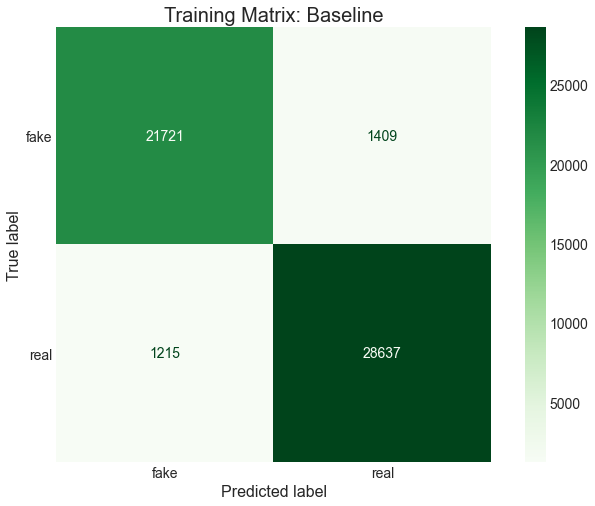

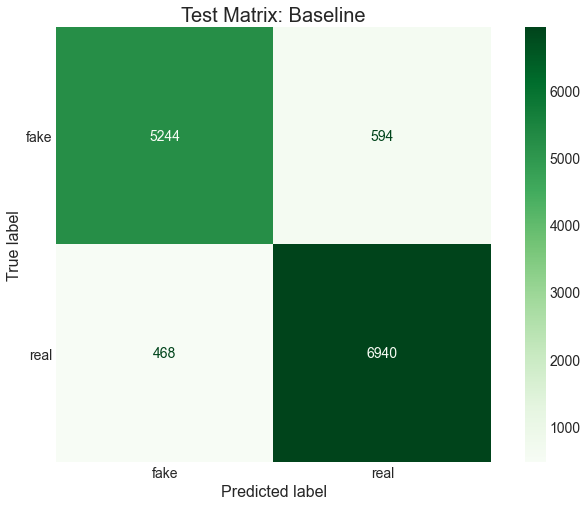

In [42]:
viz.make_network_confusion_matrices(baseline_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Baseline')

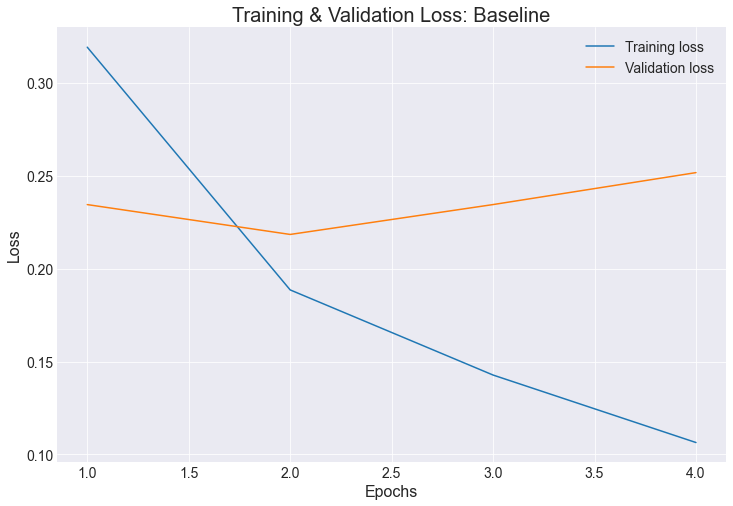

In [43]:
viz.training_graph(baseline_rnn_val_dict, 'Baseline')

### GloVe

In [34]:
word_index = tokenizer.word_index
print('There are {} unique tokens in the dataset.'.format(len(word_index)))

There are 176704 unique tokens in the dataset.


In [35]:
glove = {}
with open('glove.42B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in word_index.keys():
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [36]:
embedding_matrix = np.zeros((len(word_index) + 1, 300)) # 100 dimensions since we used 100 dimensional glove vectors
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [37]:
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=500,
                            trainable=False)

In [38]:
glove_rnn = Sequential()
glove_rnn.add(embedding_layer)
glove_rnn.add(LSTM(100, return_sequences=True))
glove_rnn.add(GlobalMaxPool1D())
glove_rnn.add(Dropout(0.5))
glove_rnn.add(Dense(100, activation='relu'))
glove_rnn.add(Dropout(0.5))
glove_rnn.add(Dense(2, activation='softmax'))
glove_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
glove_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          53011500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 100)          160400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [39]:
glove_rnn_val = glove_rnn.fit(X_train_padded,
                              y_train_rnn,
                              epochs=20,
                              batch_size=64,
                              validation_split=0.2,
                              callbacks=[callback])   

Epoch 1/20
663/663 [==============================] - 448s 675ms/step - loss: 0.3633 - accuracy: 0.8294 - val_loss: 0.2638 - val_accuracy: 0.8872
Epoch 2/20
663/663 [==============================] - 430s 648ms/step - loss: 0.2370 - accuracy: 0.9020 - val_loss: 0.2052 - val_accuracy: 0.9136
Epoch 3/20
663/663 [==============================] - 459s 693ms/step - loss: 0.2095 - accuracy: 0.9152 - val_loss: 0.2112 - val_accuracy: 0.9140
Epoch 4/20
663/663 [==============================] - 456s 688ms/step - loss: 0.1943 - accuracy: 0.9209 - val_loss: 0.1895 - val_accuracy: 0.9204
Epoch 5/20
663/663 [==============================] - 466s 703ms/step - loss: 0.1813 - accuracy: 0.9261 - val_loss: 0.1839 - val_accuracy: 0.9247
Epoch 6/20
663/663 [==============================] - 466s 704ms/step - loss: 0.1711 - accuracy: 0.9306 - val_loss: 0.1897 - val_accuracy: 0.9181
Epoch 7/20
663/663 [==============================] - 473s 713ms/step - loss: 0.1643 - accuracy: 0.9330 - val_loss: 0.1811 -

In [45]:
glove_rnn_val_dict = glove_rnn_val.history

In [49]:
tf.keras.utils.plot_model(glove_rnn)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [46]:
glove_metrics = dp.get_network_metrics(glove_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

1656/1656 [==============================] - 182s 110ms/step - loss: 0.1360 - accuracy: 0.9445
----------
Training Loss: 0.136 
Training Accuracy: 0.945
Train Average Weighted F1 Score: 0.944
Train Recall on Rarest Category: 0.896
Train Precision on Rarest Category: 0.975
Train F1 on Rarest Category: 0.934
414/414 [==============================] - 44s 107ms/step - loss: 0.1632 - accuracy: 0.9352
----------
Test Loss: 0.163 
Test Accuracy: 0.935
Test Average Weighted F1 Score: 0.935
Test Recall on Rarest Category: 0.886
Test Precision on Rarest Category: 0.964
Test F1 on Rarest Category: 0.923


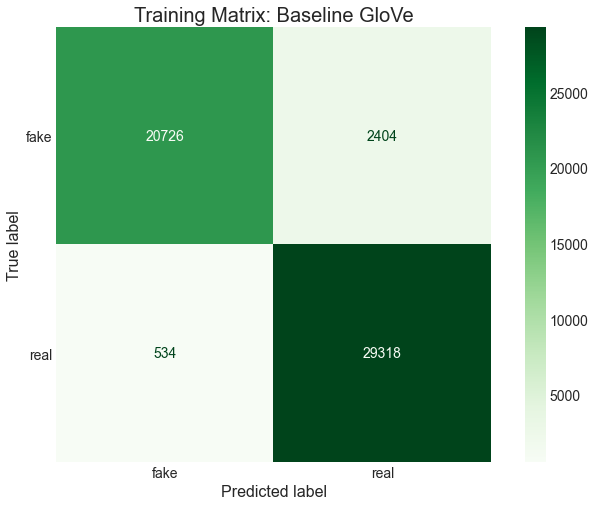

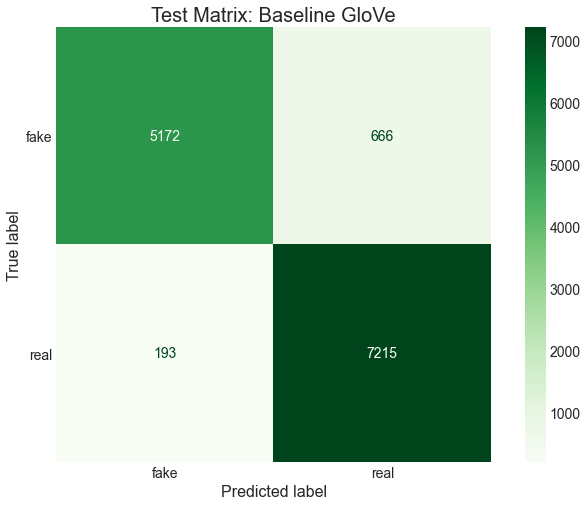

In [47]:
viz.make_network_confusion_matrices(glove_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Baseline GloVe')

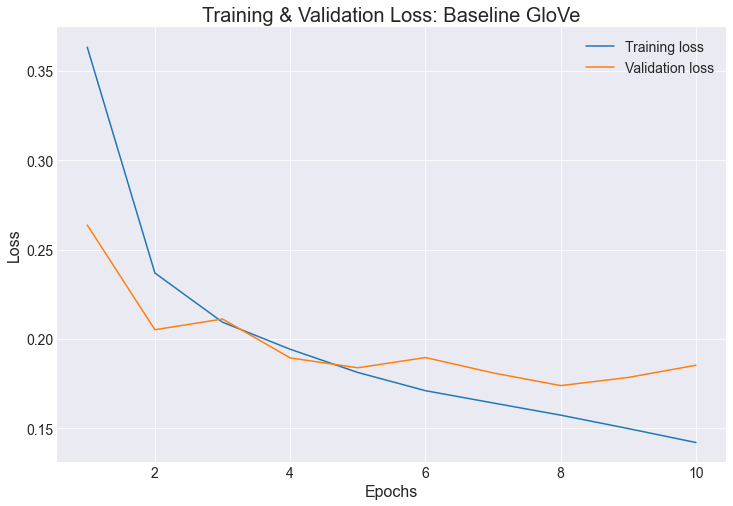

In [48]:
viz.training_graph(glove_rnn_val_dict, 'Baseline GloVe')